<a href="https://colab.research.google.com/github/yuliyaosipava/SARIMA-GARCH/blob/main/ARIMA%2BGarch_%D0%A5%D0%BE%D0%BB%D1%8C%D1%82%D0%B0_%D0%92%D0%B8%D0%BD%D0%BD%D0%B5%D1%80%D1%81%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving OLA3_sred_brest3.xlsx to OLA3_sred_brest3 (1).xlsx


In [ ]:
# Загрузка данных

data = pd.read_excel('OLA3_sred_brest3.xlsx')
print(data.columns)

# Преобразование столбца дат в формат datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Фильтрация данных с 2016 года


# фильтрация между маем 2016 и маем 2025 включительно
data = data.loc[
    (data['Date'] >= '2016-01') &
    (data['Date'] <= '2025-06')
]


# Установка столбца даты в качестве индекса
data.set_index('Date', inplace=True)

# Ваши данные серии
series = data['series1']
series

Index(['Date', 'series1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25'],
      dtype='object')


,series1
Date,
2016-01-01,6606.600000
2016-02-01,6976.569600
2016-03-01,7730.039117
2016-04-01,7312.617004
2016-05-01,7144.426813
...,...
2025-02-01,48785.082339
2025-03-01,52443.963515
2025-04-01,49087.549850


In [ ]:
# Install the library if necessary
!pip install pmdarima

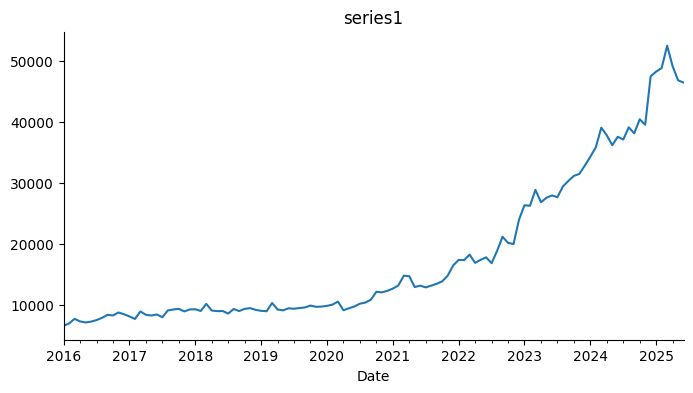

In [ ]:
# @title series1

from matplotlib import pyplot as plt
data['series1'].plot(kind='line', figsize=(8, 4), title='series1')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

print(data.columns)
print(series)

# Разделение данных на тренировочную (до 2023-12) и тестовую (2024) выборки
train_data = series[:'2023-12']
test_data = series['2024-01':]

# Построение и обучение модели AutoARIMA
model = auto_arima(train_data,
                   seasonal=True,
                   m=12,
                   suppress_warnings=True)
model.fit(train_data)

# Получение прогнозов на тестовый период
forecast = model.predict(n_periods=len(test_data))
forecast_index = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='MS')
forecast_series = pd.Series(forecast, index=forecast_index)



# Вывод модели
print(model.summary())
# Оценка точности модели (RMSE и MAPE)
rmse = np.sqrt(mean_squared_error(test_data, forecast_series))
mape = mean_absolute_percentage_error(test_data, forecast_series) * 100  # Переводим в проценты
print(f'RMSE: {rmse}')
print(f'MAPE: {mape:.2f}%')

# Построение графика
plt.figure(figsize=(12, 7))
plt.plot(train_data.index, train_data, label='Тренировочные данные')
plt.plot(test_data.index, test_data, label='Тестовые данные', color='green')
plt.plot(forecast_index, forecast_series, label='Прогноз', linestyle='--', color='orange')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Тренировочные данные, тестовые данные и прогноз')
plt.legend()
plt.grid(True)
plt.show()



ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pmdarima
import arch
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import shapiro, anderson, cramervonmises, chisquare, probplot
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Чтение данных
data = pd.read_excel('OLA3_sred_brest1.xlsx')
print(data.columns)

# Преобразование столбца дат
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])

# Сохранение данных за 2024 год для оценки точности модели
data_2024 = data.loc[data['Date'].dt.year == 2024].copy()
data_2024.set_index('Date', inplace=True)

# Фильтрация данных до января 2024 года
data = data.loc[data['Date'] <= '2023-12']
data.set_index('Date', inplace=True)
series = data['series1']

# Построение модели SARIMA
sarima_model = SARIMAX(series, order=(0, 1, 0), seasonal_order=(1, 1, 0, 12))
sarima_model_fitted = sarima_model.fit(disp=False)
print(sarima_model_fitted.summary())

# Получение остатков SARIMA
sarima_residuals = sarima_model_fitted.resid
print(sarima_residuals)

# ===== ДОБАВЛЕНИЕ ТЕСТОВ НА НОРМАЛЬНОСТЬ ОСТАТКОВ =====

# Тест Шапиро-Уилка
shapiro_test = shapiro(sarima_residuals)
print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}')

# Тест Андерсона-Дарлинга
anderson_test = anderson(sarima_residuals)
print('\nAnderson-Darling Test:')
print(f'Statistic: {anderson_test.statistic:.4f}')
for i in range(len(anderson_test.critical_values)):
    sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
    if anderson_test.statistic < cv:
        result = 'Accept'
    else:
        result = 'Reject'
    print(f'At {sl}% significance level: Critical Value = {cv:.4f}, Result = {result}')

# Тест Крамера-фон Мизеса
cramervonmises_test = cramervonmises(sarima_residuals, 'norm')
print('\nCramer-Von Mises Test:')
print(f'Statistic: {cramervonmises_test.statistic:.4f}, p-value: {cramervonmises_test.pvalue:.4f}')

# Хи-квадрат тест Пирсона
num_bins = 10  # Количество интервалов
hist, bin_edges = np.histogram(sarima_residuals, bins=num_bins)

# Ожидаемые частоты при нормальном распределении
expected_freq = len(sarima_residuals) * np.diff(
    stats.norm.cdf(bin_edges, loc=np.mean(sarima_residuals), scale=np.std(sarima_residuals))
)

# Удаление нулевых ожидаемых частот и соответствующих наблюдаемых частот
mask = expected_freq > 0
hist = hist[mask]
expected_freq = expected_freq[mask]

# Добавление небольшого значения (эпсилон) к ожидаемым частотам
eps = 1e-10
expected_freq += eps

# Масштабирование ожидаемых частот, чтобы суммы совпадали
expected_freq *= hist.sum() / expected_freq.sum()

# Проверка сумм
print(f"\nSum of observed frequencies: {hist.sum()}")
print(f"Sum of expected frequencies: {expected_freq.sum()}")

# Выполнение хи-квадрат теста
chisq_stat, p_value = chisquare(f_obs=hist, f_exp=expected_freq)
print('\nChi-Square Test:')
print(f'Statistic: {chisq_stat:.4f}, p-value: {p_value:.4f}')

# ===== ПРОДОЛЖЕНИЕ КОДА =====

# Подгонка модели GARCH(1,1) на остатках SARIMA
garch = arch.arch_model(sarima_residuals, vol='Garch', p=1, q=1, mean='Zero')
garch_fitted = garch.fit()

# Прогноз SARIMA на 12 месяцев вперед
sarima_forecast = sarima_model_fitted.get_forecast(steps=12)
predicted_mu = sarima_forecast.predicted_mean

# Прогноз дисперсии из модели GARCH на 12 месяцев вперед
garch_forecast = garch_fitted.forecast(horizon=12)
forecast_variances = garch_forecast.variance.values[-1, :]

# Симуляция остатков с использованием прогнозируемой дисперсии
np.random.seed(0)  # Для воспроизводимости
simulated_residuals = np.random.normal(loc=0, scale=np.sqrt(forecast_variances))

# Комбинация предсказаний SARIMA и смоделированных остатков GARCH
predictions = predicted_mu + simulated_residuals

# Получение данных за 2024 год для оценки точности модели
true_values = data_2024['series1'].values

# Расчет оценок модели
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))
mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100

print(f'\nMAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

# Построение графика
plt.figure(figsize=(12, 7))
plt.plot(series.index, series, label='Исходные данные')
forecast_dates = pd.date_range(start=series.index[-1] + pd.offsets.MonthBegin(), periods=12, freq='MS')
plt.plot(forecast_dates, predictions, label='Прогноз', linestyle='--', color='orange')
plt.plot(data_2024.index, data_2024['series1'], label='Фактические данные за 2024 год', linestyle=':', color='green')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Исходные данные, прогноз и фактические данные за 2024 год')
plt.legend()
plt.grid(True)
plt.show()

# ===== ДОБАВЛЕНИЕ ВИЗУАЛИЗАЦИИ ДИАГНОСТИКИ ОСТАТКОВ =====

# Гистограмма остатков
plt.figure(figsize=(12, 6))
plt.hist(sarima_residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Гистограмма остатков SARIMA модели')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Q-Q график для проверки нормальности остатков
plt.figure(figsize=(12, 6))
probplot(sarima_residuals, dist="norm", plot=plt)
plt.title('Q-Q график остатков SARIMA модели')
plt.grid(True)
plt.show()

# ACF и PACF остатков
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(sarima_residuals, ax=plt.gca(), lags=30)
plt.title('ACF остатков SARIMA модели')

plt.subplot(1, 2, 2)
plot_pacf(sarima_residuals, ax=plt.gca(), lags=30)
plt.title('PACF остатков SARIMA модели')

plt.tight_layout()
plt.show()


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

удаление выбросов

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import arch
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import shapiro, anderson, cramervonmises, chisquare, probplot
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Чтение данных
data = pd.read_excel('OLA3_sred_brest1.xlsx')
print(data.columns)

# Преобразование столбца дат
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])

# Сохранение данных за 2024 год для оценки точности модели
data_2024 = data.loc[data['Date'].dt.year == 2024].copy()
data_2024.set_index('Date', inplace=True)

# Фильтрация данных до января 2024 года
data = data.loc[data['Date'] <= '2023-12']
data.set_index('Date', inplace=True)
series = data['series1']

# Применение медианной регрессии для сглаживания выбросов
X = np.arange(len(series)).reshape(-1, 1)
y = series.values
model = sm.QuantReg(y, sm.add_constant(X))
result = model.fit(q=0.5)
series_medreg = result.predict(sm.add_constant(X))

# Построение модели SARIMA на данных с медианной регрессией
sarima_model = SARIMAX(series_medreg, order=(0,1, 0), seasonal_order=(0, 1,0, 12))
sarima_model_fitted = sarima_model.fit(disp=False)
print(sarima_model_fitted.summary())

# Получение остатков SARIMA на данных с медианной регрессией
sarima_residuals = sarima_model_fitted.resid
print(sarima_residuals)

# ===== ДОБАВЛЕНИЕ ТЕСТОВ НА НОРМАЛЬНОСТЬ ОСТАТКОВ =====

# Тест Шапиро-Уилка
shapiro_test = shapiro(sarima_residuals)
print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}')

# Тест Андерсона-Дарлинга
anderson_test = anderson(sarima_residuals)
print('\nAnderson-Darling Test:')
print(f'Statistic: {anderson_test.statistic:.4f}')
for i in range(len(anderson_test.critical_values)):
    sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
    if anderson_test.statistic < cv:
        result = 'Accept'
    else:
        result = 'Reject'
    print(f'At {sl}% significance level: Critical Value = {cv:.4f}, Result = {result}')

# Тест Крамера-фон Мизеса
cramervonmises_test = cramervonmises(sarima_residuals, 'norm')
print('\nCramer-Von Mises Test:')
print(f'Statistic: {cramervonmises_test.statistic:.4f}, p-value: {cramervonmises_test.pvalue:.4f}')

# Хи-квадрат тест Пирсона
num_bins = 10  # Количество интервалов
hist, bin_edges = np.histogram(sarima_residuals, bins=num_bins)

# Ожидаемые частоты при нормальном распределении
expected_freq = len(sarima_residuals) * np.diff(
    stats.norm.cdf(bin_edges, loc=np.mean(sarima_residuals), scale=np.std(sarima_residuals))
)

# Удаление нулевых ожидаемых частот и соответствующих наблюдаемых частот
mask = expected_freq > 0
hist = hist[mask]
expected_freq = expected_freq[mask]

# Добавление небольшого значения (эпсилон) к ожидаемым частотам
eps = 1e-10
expected_freq += eps

# Масштабирование ожидаемых частот, чтобы суммы совпадали
expected_freq *= hist.sum() / expected_freq.sum()

# Выполнение хи-квадрат теста
chisq_stat, p_value = chisquare(f_obs=hist, f_exp=expected_freq)
print('\nChi-Square Test:')
print(f'Statistic: {chisq_stat:.4f}, p-value: {p_value:.4f}')

# ===== ПРОДОЛЖЕНИЕ КОДА =====

# Подгонка модели GARCH(1,1) на остатках SARIMA
garch = arch.arch_model(sarima_residuals, vol='Garch', p=1, q=1, mean='Zero')
garch_fitted = garch.fit()

# Прогноз SARIMA на 12 месяцев вперед
sarima_forecast = sarima_model_fitted.get_forecast(steps=12)
predicted_mu = sarima_forecast.predicted_mean

# Прогноз дисперсии из модели GARCH на 12 месяцев вперед
garch_forecast = garch_fitted.forecast(horizon=12)
forecast_variances = garch_forecast.variance.values[-1, :]

# Симуляция остатков с использованием прогнозируемой дисперсии
np.random.seed(0)  # Для воспроизводимости
simulated_residuals = np.random.normal(loc=0, scale=np.sqrt(forecast_variances))

# Комбинация предсказаний SARIMA и смоделированных остатков GARCH
predictions = predicted_mu + simulated_residuals

# Получение данных за 2024 год для оценки точности модели
true_values = data_2024['series1'].values

# Расчет оценок модели
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))
mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100

print(f'\nMAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

# Построение графика
plt.figure(figsize=(12, 7))
plt.plot(series.index, series, label='Исходные данные')
forecast_dates = pd.date_range(start=series.index[-1] + pd.offsets.MonthBegin(), periods=12, freq='MS')
plt.plot(forecast_dates, predictions, label='Прогноз', linestyle='--', color='orange')
plt.plot(data_2024.index, data_2024['series1'], label='Фактические данные за 2024 год', linestyle=':', color='green')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Исходные данные, прогноз и фактические данные за 2024 год')
plt.legend()
plt.grid(True)
plt.show()

# ===== ДОБАВЛЕНИЕ ВИЗУАЛИЗАЦИИ ДИАГНОСТИКИ ОСТАТКОВ =====

# Гистограмма остатков
plt.figure(figsize=(12, 6))
plt.hist(sarima_residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Гистограмма остатков SARIMA модели')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Q-Q график для проверки нормальности остатков
plt.figure(figsize=(12, 6))
probplot(sarima_residuals, dist="norm", plot=plt)
plt.title('Q-Q график остатков SARIMA модели')
plt.grid(True)
plt.show()

# ACF и PACF остатков
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(sarima_residuals, ax=plt.gca(), lags=30)
plt.title('ACF остатков SARIMA модели')

plt.subplot(1, 2, 2)
plot_pacf(sarima_residuals, ax=plt.gca(), lags=30)
plt.title('PACF остатков SARIMA модели')

plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'OLA3_sred_brest1.xlsx'

In [ ]:
import pandas as pd
import numpy as np
import pmdarima
import arch
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import shapiro, anderson, cramervonmises, chisquare
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Чтение данных
data = pd.read_excel('OLA3_sred_brest1.xlsx')
print(data.columns)

# Преобразование столбца дат
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])

# Сохранение данных за 2024 год для оценки точности модели
data_2024 = data.loc[data['Date'].dt.year == 2024].copy()
data_2024.set_index('Date', inplace=True)

# Фильтрация данных до января 2024 года
data = data.loc[data['Date'] <= '2023-12']
data.set_index('Date', inplace=True)
series = data['series1']

# Построение модели SARIMA
sarima_model = SARIMAX(series, order=(0,1, 0), seasonal_order=(1, 0, 0, 12))
sarima_model_fitted = sarima_model.fit(disp=False)
print(sarima_model_fitted.summary())

# Получение остатков SARIMA
sarima_residuals = sarima_model_fitted.resid
print(sarima_residuals)

# ===== ДОБАВЛЕНИЕ ТЕСТОВ НА НОРМАЛЬНОСТЬ ОСТАТКОВ =====

# Тест Шапиро-Уилка
shapiro_test = shapiro(sarima_residuals)
print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}')

# Тест Андерсона-Дарлинга
anderson_test = anderson(sarima_residuals)
print('\nAnderson-Darling Test:')
print(f'Statistic: {anderson_test.statistic:.4f}')
for i in range(len(anderson_test.critical_values)):
    sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
    if anderson_test.statistic < cv:
        result = 'Accept'
    else:
        result = 'Reject'
    print(f'At {sl}% significance level: Critical Value = {cv:.4f}, Result = {result}')

# Тест Крамера-фон Мизеса
cramervonmises_test = cramervonmises(sarima_residuals, 'norm')
print('\nCramer-Von Mises Test:')
print(f'Statistic: {cramervonmises_test.statistic:.4f}, p-value: {cramervonmises_test.pvalue:.4f}')

# Хи-квадрат тест Пирсона
num_bins = 10  # Количество интервалов
hist, bin_edges = np.histogram(sarima_residuals, bins=num_bins)

# Ожидаемые частоты при нормальном распределении
expected_freq = len(sarima_residuals) * np.diff(
    stats.norm.cdf(bin_edges, loc=np.mean(sarima_residuals), scale=np.std(sarima_residuals))
)

# Удаление нулевых ожидаемых частот и соответствующих наблюдаемых частот
mask = expected_freq > 0
hist = hist[mask]
expected_freq = expected_freq[mask]

# Добавление небольшого значения (эпсилон) к ожидаемым частотам
eps = 1e-10
expected_freq += eps

# Масштабирование ожидаемых частот, чтобы суммы совпадали
expected_freq *= hist.sum() / expected_freq.sum()

# Проверка сумм
print(f"\nSum of observed frequencies: {hist.sum()}")
print(f"Sum of expected frequencies: {expected_freq.sum()}")

# Выполнение хи-квадрат теста
chisq_stat, p_value = chisquare(f_obs=hist, f_exp=expected_freq)
print('\nChi-Square Test:')
print(f'Statistic: {chisq_stat:.4f}, p-value: {p_value:.4f}')

# ===== ПРОДОЛЖЕНИЕ КОДА =====

# Тест на автокорреляцию (тест Льюнг-Бокса)
lb_test = acorr_ljungbox(sarima_residuals, lags=[10, 20, 30], return_df=True)
print("Результаты теста Льюнг-Бокса:\n", lb_test)

# Тест на наличие условной гетероскедастичности (ARCH тест)
arch_test = het_arch(sarima_residuals)
print("Результаты теста ARCH:\n", arch_test)

# Подгонка модели TGARCH(1,1) на остатках SARIMA
tgarch = arch.arch_model(sarima_residuals, vol='Garch', p=1, o=1, q=1, mean='Zero')
tgarch_fitted = tgarch.fit()

# Прогноз SARIMA на 12 месяцев вперед
sarima_forecast = sarima_model_fitted.get_forecast(steps=12)
predicted_mu = sarima_forecast.predicted_mean

# Прогноз дисперсии из модели TGARCH на 12 месяцев вперед
tgarch_forecast = tgarch_fitted.forecast(horizon=12)
forecast_variances = tgarch_forecast.variance.values[-1, :]

# Симуляция остатков с использованием прогнозируемой дисперсии
np.random.seed(0)  # Для воспроизводимости
simulated_residuals = np.random.normal(loc=0, scale=np.sqrt(forecast_variances))

# Комбинация предсказаний SARIMA и смоделированных остатков TGARCH
predictions = predicted_mu + simulated_residuals

# Получение данных за 2024 год для оценки точности модели
true_values = data_2024['series1'].values

# Расчет оценок модели
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))
mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100

print(f'\nMAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

# Построение графика
plt.figure(figsize=(12, 7))
plt.plot(series.index, series, label='Исходные данные')
forecast_dates = pd.date_range(start=series.index[-1] + pd.offsets.MonthBegin(), periods=12, freq='MS')
plt.plot(forecast_dates, predictions, label='Прогноз', linestyle='--', color='orange')
plt.plot(data_2024.index, data_2024['series1'], label='Фактические данные за 2024 год', linestyle=':', color='green')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Исходные данные, прогноз и фактические данные за 2024 год')
plt.legend()
plt.grid(True)
plt.show()

# ===== ДОБАВЛЕНИЕ ДИАГНОСТИКИ ОСТАТКОВ =====

# Гистограмма остатков
plt.figure(figsize=(12, 6))
plt.hist(sarima_residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Гистограмма остатков SARIMA модели')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Q-Q график для проверки нормальности остатков
plt.figure(figsize=(12, 6))
stats.probplot(sarima_residuals, dist="norm", plot=plt)
plt.title('Q-Q график остатков SARIMA модели')
plt.grid(True)
plt.show()

# Графики ACF и PACF для остатков
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(sarima_residuals, ax=plt.gca(), lags=30)
plt.title('ACF остатков SARIMA модели')

plt.subplot(122)
plot_pacf(sarima_residuals, ax=plt.gca(), lags=30)
plt.title('PACF остатков SARIMA модели')

plt.tight_layout()
plt.show()


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
import pandas as pd
import numpy as np
import arch
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from scipy.stats import shapiro, anderson, cramervonmises, chisquare, probplot
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Чтение данных
data = pd.read_excel('OLA_ind9.xlsx')

# Преобразование столбца дат
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])

# Фильтрация данных до декабря 2024 года
data = data.loc[data['Date'] <= '2024-12']
data.set_index('Date', inplace=True)
series = data['series1']

# Построение модели SARIMA
sarima_model = SARIMAX(series, order=(1, 0, 0), seasonal_order=(1, 0, 0, 12))
sarima_model_fitted = sarima_model.fit(disp=False)
print(sarima_model_fitted.summary())

# Получение остатков SARIMA
sarima_residuals = sarima_model_fitted.resid

# ===== ТЕСТЫ НА НОРМАЛЬНОСТЬ ОСТАТКОВ =====

# Тест Шапиро-Уилка
shapiro_test = shapiro(sarima_residuals)
print('\nShapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}')

# Тест Андерсона-Дарлинга
anderson_test = anderson(sarima_residuals)
print('\nAnderson-Darling Test:')
print(f'Statistic: {anderson_test.statistic:.4f}')
for i in range(len(anderson_test.critical_values)):
    sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
    result = 'Reject' if anderson_test.statistic > cv else 'Accept'
    print(f'At {sl}% significance level: Critical Value = {cv:.4f}, Result = {result}')

# Тест Крамера-фон Мизеса
cramervonmises_test = cramervonmises(sarima_residuals, 'norm')
print('\nCramer-Von Mises Test:')
print(f'Statistic: {cramervonmises_test.statistic:.4f}, p-value: {cramervonmises_test.pvalue:.4f}')

# Хи-квадрат тест Пирсона
num_bins = 10  # Количество интервалов
hist, bin_edges = np.histogram(sarima_residuals, bins=num_bins)

# Ожидаемые частоты при нормальном распределении
expected_freq = len(sarima_residuals) * np.diff(
    stats.norm.cdf(bin_edges, loc=np.mean(sarima_residuals), scale=np.std(sarima_residuals))
)

# Удаление нулевых ожидаемых частот и соответствующих наблюдаемых частот
mask = expected_freq > 0
hist = hist[mask]
expected_freq = expected_freq[mask]

# Добавление небольшого значения (эпсилон) к ожидаемым частотам
eps = 1e-10
expected_freq += eps

# Масштабирование ожидаемых частот, чтобы суммы совпадали
expected_freq *= hist.sum() / expected_freq.sum()

# Проверка сумм
print(f"\nSum of observed frequencies: {hist.sum()}")
print(f"Sum of expected frequencies: {expected_freq.sum()}")

# Выполнение хи-квадрат теста
chisq_stat, p_value = chisquare(f_obs=hist, f_exp=expected_freq)
print('\nChi-Square Test:')
print(f'Statistic: {chisq_stat:.4f}, p-value: {p_value:.4f}')

# ===== ДИАГНОСТИКА ОСТАТКОВ =====

# Тест на автокорреляцию (тест Льюнг-Бокса)
lb_test = acorr_ljungbox(sarima_residuals, lags=[10, 20, 30], return_df=True)
print("\nРезультаты теста Льюнг-Бокса:")
print(lb_test)

# Тест на наличие условной гетероскедастичности (ARCH тест)
arch_test = het_arch(sarima_residuals)
print("\nРезультаты теста ARCH:")
print(f'LM Statistic: {arch_test[0]:.4f}, p-value: {arch_test[1]:.4f}')

# Подгонка модели TGARCH(1,1) на остатках SARIMA
tgarch = arch.arch_model(sarima_residuals, vol='GARCH', p=1, o=1, q=1, mean='Zero')
tgarch_fitted = tgarch.fit()
print(tgarch_fitted.summary())

# Прогноз SARIMA на 12 месяцев вперед (2025 год)
sarima_forecast = sarima_model_fitted.get_forecast(steps=12)
predicted_mu = sarima_forecast.predicted_mean

# Прогноз дисперсии из модели TGARCH на 12 месяцев вперед
tgarch_forecast = tgarch_fitted.forecast(horizon=12)
forecast_variances = tgarch_forecast.variance.iloc[-12:].values.flatten()

# Симуляция остатков с использованием прогнозируемой дисперсии
np.random.seed(0)  # Для воспроизводимости
simulated_residuals = np.random.normal(loc=0, scale=np.sqrt(forecast_variances))

# Комбинация предсказаний SARIMA и смоделированных остатков TGARCH
predictions = predicted_mu + simulated_residuals

# Вывод прогнозных значений для каждого месяца 2025 года
forecast_dates = pd.date_range(start=series.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': predictions.values})
print("\nПрогнозные значения на 2025 год:")
print(forecast_df)

# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(series.index, series, label='Исходные данные')
plt.plot(forecast_dates, predictions, label='Прогноз на 2025 год', linestyle='--', color='orange')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Исходные данные до декабря 2024 года и прогноз на 2025 год')
plt.legend()
plt.grid(True)
plt.show()

# Построение графиков ACF и PACF для остатков
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(sarima_residuals, ax=plt.gca(), lags=30)
plt.title('ACF остатков SARIMA модели')

plt.subplot(1, 2, 2)
plot_pacf(sarima_residuals, ax=plt.gca(), lags=30)
plt.title('PACF остатков SARIMA модели')

plt.tight_layout()
plt.show()

# Диагностика остатков
# Гистограмма остатков
plt.figure(figsize=(12, 6))
plt.hist(sarima_residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Гистограмма остатков SARIMA модели')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Q-Q график для проверки нормальности остатков
plt.figure(figsize=(12, 6))
probplot(sarima_residuals, dist="norm", plot=plt)
plt.title('Q-Q график остатков SARIMA модели')
plt.grid(True)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'OLA_ind9.xlsx'

t-распределение

In [ ]:
import pandas as pd
import numpy as np
import pmdarima
import arch
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import shapiro, anderson, cramervonmises, chisquare
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Масштабирование данных для предотвращения проблемы с конвергенцией
series_scaled = series * 0.01

# Построение модели SARIMA
sarima_model = SARIMAX(series_scaled, order=(0, 1, 0), seasonal_order=(1, 1, 0, 12))
sarima_model_fitted = sarima_model.fit(disp=False)
print(sarima_model_fitted.summary())

# Получение остатков SARIMA
sarima_residuals = sarima_model_fitted.resid
print(sarima_residuals)

# Подгонка модели TGARCH(1,1) с GED-распределением на остатках SARIMA
tgarch_ged = arch.arch_model(sarima_residuals, vol='Garch', p=1, o=1, q=1, dist='ged', mean='Zero')
tgarch_ged_fitted = tgarch_ged.fit()

# Прогноз SARIMA на 12 месяцев вперед
sarima_forecast = sarima_model_fitted.get_forecast(steps=12)
predicted_mu = sarima_forecast.predicted_mean

# Прогноз дисперсии из модели TGARCH на 12 месяцев вперед
tgarch_ged_forecast = tgarch_ged_fitted.forecast(horizon=12)
forecast_variances = tgarch_ged_forecast.variance.values[-1, :]

# Симуляция остатков с использованием прогнозируемой дисперсии
np.random.seed(0)  # Для воспроизводимости
simulated_residuals = np.random.normal(loc=0, scale=np.sqrt(forecast_variances))

# Комбинация предсказаний SARIMA и смоделированных остатков TGARCH
predictions = predicted_mu + simulated_residuals

# Масштабирование предсказаний обратно
predictions_unscaled = predictions / 0.01

# Получение данных за 2024 год для оценки точности модели
true_values = data_2024['series1'].values

# Расчет оценок модели
mae = mean_absolute_error(true_values, predictions_unscaled)
rmse = np.sqrt(mean_squared_error(true_values, predictions_unscaled))
mape = np.mean(np.abs((true_values - predictions_unscaled) / true_values)) * 100

print(f'\nMAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

# Построение графика
plt.figure(figsize=(12, 7))
plt.plot(series.index, series, label='Исходные данные')
forecast_dates = pd.date_range(start=series.index[-1] + pd.offsets.MonthBegin(), periods=12, freq='MS')
plt.plot(forecast_dates, predictions_unscaled, label='Прогноз', linestyle='--', color='orange')
plt.plot(data_2024.index, data_2024['series1'], label='Фактические данные за 2024 год', linestyle=':', color='green')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Исходные данные, прогноз и фактические данные за 2024 год')
plt.legend()
plt.grid(True)
plt.show()

# Построение графиков ACF и PACF для остатков
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(sarima_residuals, ax=plt.gca(), lags=30)
plt.title('ACF остатков SARIMA модели')

plt.subplot(122)
plot_pacf(sarima_residuals, ax=plt.gca(), lags=30)
plt.title('PACF остатков SARIMA модели')

plt.tight_layout()
plt.show()

# Диагностика остатков
# Гистограмма остатков
plt.figure(figsize=(12, 6))
plt.hist(sarima_residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Гистограмма остатков SARIMA модели')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Q-Q график для проверки нормальности остатков
plt.figure(figsize=(12, 6))
stats.probplot(sarima_residuals, dist="norm", plot=plt)
plt.title('Q-Q график остатков SARIMA модели')
plt.grid(True)
plt.show()


GED (Generalized Error Distribution)

In [ ]:
import pandas as pd
import numpy as np
import pmdarima
import arch
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import shapiro, anderson, cramervonmises, chisquare
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Построение модели SARIMA
sarima_model = SARIMAX(series, order=(0,1,0), seasonal_order=(1, 1, 0, 12))
sarima_model_fitted = sarima_model.fit(disp=False)
print(sarima_model_fitted.summary())

# Получение остатков SARIMA
sarima_residuals = sarima_model_fitted.resid
print(sarima_residuals)

# Подгонка модели TGARCH(1,1) с GED-распределением на остатках SARIMA
tgarch_ged = arch.arch_model(sarima_residuals, vol='Garch', p=1, o=1, q=1, dist='ged', mean='Zero')
tgarch_ged_fitted = tgarch_ged.fit()

# Прогноз SARIMA на 12 месяцев вперед
sarima_forecast = sarima_model_fitted.get_forecast(steps=12)
predicted_mu = sarima_forecast.predicted_mean

# Прогноз дисперсии из модели TGARCH на 12 месяцев вперед
tgarch_ged_forecast = tgarch_ged_fitted.forecast(horizon=12)
forecast_variances = tgarch_ged_forecast.variance.values[-1, :]

# Симуляция остатков с использованием прогнозируемой дисперсии
np.random.seed(0)  # Для воспроизводимости
simulated_residuals = np.random.normal(loc=0, scale=np.sqrt(forecast_variances))

# Комбинация предсказаний SARIMA и смоделированных остатков TGARCH
predictions = predicted_mu + simulated_residuals

# Получение данных за 2024 год для оценки точности модели
true_values = data_2024['series1'].values

# Расчет оценок модели
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))
mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100

print(f'\nMAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

# Построение графика
plt.figure(figsize=(12, 7))
plt.plot(series.index, series, label='Исходные данные')
forecast_dates = pd.date_range(start=series.index[-1] + pd.offsets.MonthBegin(), periods=12, freq='MS')
plt.plot(forecast_dates, predictions, label='Прогноз', linestyle='--', color='orange')
plt.plot(data_2024.index, data_2024['series1'], label='Фактические данные за 2024 год', linestyle=':', color='green')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Исходные данные, прогноз и фактические данные за 2024 год')
plt.legend()
plt.grid(True)
plt.show()

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

Прогноз по модели TGARCH на 2025 год

In [ ]:
import pandas as pd
import numpy as np
import pmdarima
import arch
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import shapiro, anderson, cramervonmises, chisquare
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Чтение данных
data = pd.read_excel('OLA3_sred_brest1.xlsx')
print(data.columns)

# Преобразование столбца дат
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])

# Сохранение данных за 2024 год для оценки точности модели
data_2024 = data.loc[data['Date'].dt.year == 2024].copy()
data_2024.set_index('Date', inplace=True)

# Фильтрация данных до января 2024 года
data = data.loc[data['Date'] <= '2023-12']
data.set_index('Date', inplace=True)
series = data['series1']

# Построение модели SARIMA
sarima_model = SARIMAX(series, order=(0, 2, 0), seasonal_order=(1, 1, 0, 12))
sarima_model_fitted = sarima_model.fit(disp=False)
print(sarima_model_fitted.summary())

# Получение остатков SARIMA
sarima_residuals = sarima_model_fitted.resid
print(sarima_residuals)

# Диагностика остатков SARIMA

# Гистограмма остатков
plt.figure(figsize=(12, 6))
plt.hist(sarima_residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Гистограмма остатков SARIMA')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Q-Q график для проверки нормальности остатков
plt.figure(figsize=(12, 6))
stats.probplot(sarima_residuals, dist="norm", plot=plt)
plt.title('Q-Q график остатков SARIMA')
plt.grid(True)
plt.show()

# Тесты на нормальность остатков
# Тест Шапиро-Уилка
shapiro_test = shapiro(sarima_residuals)
print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}')

# Тест Андерсона-Дарлинга
anderson_test = anderson(sarima_residuals)
print('\nAnderson-Darling Test:')
print(f'Statistic: {anderson_test.statistic:.4f}')
for i in range(len(anderson_test.critical_values)):
    sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
    if anderson_test.statistic < cv:
        result = 'Accept'
    else:
        result = 'Reject'
    print(f'At {sl}% significance level: Critical Value = {cv:.4f}, Result = {result}')

# Тест Крамера-фон Мизеса
cramervonmises_test = cramervonmises(sarima_residuals, 'norm')
print('\nCramer-Von Mises Test:')
print(f'Statistic: {cramervonmises_test.statistic:.4f}, p-value: {cramervonmises_test.pvalue:.4f}')

# Тест Льюнга-Бокса на автокорреляцию
ljungbox_test = acorr_ljungbox(sarima_residuals, lags=[12], return_df=True)
print('\nLjung-Box Test (lag=12):')
print(ljungbox_test)

# ACF и PACF остатка
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(sarima_residuals, ax=plt.gca(), lags=30)
plt.title('ACF остатков SARIMA')

plt.subplot(1, 2, 2)
plot_pacf(sarima_residuals, ax=plt.gca(), lags=30)
plt.title('PACF остатков SARIMA')

plt.tight_layout()
plt.show()

# Тест на ARCH эффекты
arch_test = het_arch(sarima_residuals)
print('\nARCH Test:')
print(f'Statistic: {arch_test[0]:.4f}, p-value: {arch_test[1]:.4f}')

# Подгонка модели TGARCH(1,1) с GED-распределением на остатках SARIMA
tgarch_ged = arch.arch_model(sarima_residuals, vol='Garch', p=1, o=1, q=1, dist='ged', mean='Zero')
tgarch_ged_fitted = tgarch_ged.fit()

# Прогноз SARIMA на 12 месяцев вперед
sarima_forecast = sarima_model_fitted.get_forecast(steps=12)
predicted_mu = sarima_forecast.predicted_mean

# Прогноз дисперсии из модели TGARCH на 12 месяцев вперед
tgarch_ged_forecast = tgarch_ged_fitted.forecast(horizon=12)
forecast_variances = tgarch_ged_forecast.variance.values[-1, :]

# Симуляция остатков с использованием прогнозируемой дисперсии
np.random.seed(0)  # Для воспроизводимости
simulated_residuals = np.random.normal(loc=0, scale=np.sqrt(forecast_variances))

# Комбинация предсказаний SARIMA и смоделированных остатков TGARCH
predictions_2024 = predicted_mu + simulated_residuals

# Получение данных за 2024 год для оценки точности модели
true_values = data_2024['series1'].values

# Расчет оценок модели
mae = mean_absolute_error(true_values, predictions_2024)
rmse = np.sqrt(mean_squared_error(true_values, predictions_2024))
mape = np.mean(np.abs((true_values - predictions_2024) / true_values)) * 100

print(f'\nMAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

# Построение графика для 2024 года
plt.figure(figsize=(12, 7))
plt.plot(series.index, series, label='Исходные данные')
forecast_dates_2024 = pd.date_range(start=series.index[-1] + pd.offsets.MonthBegin(), periods=12, freq='MS')


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


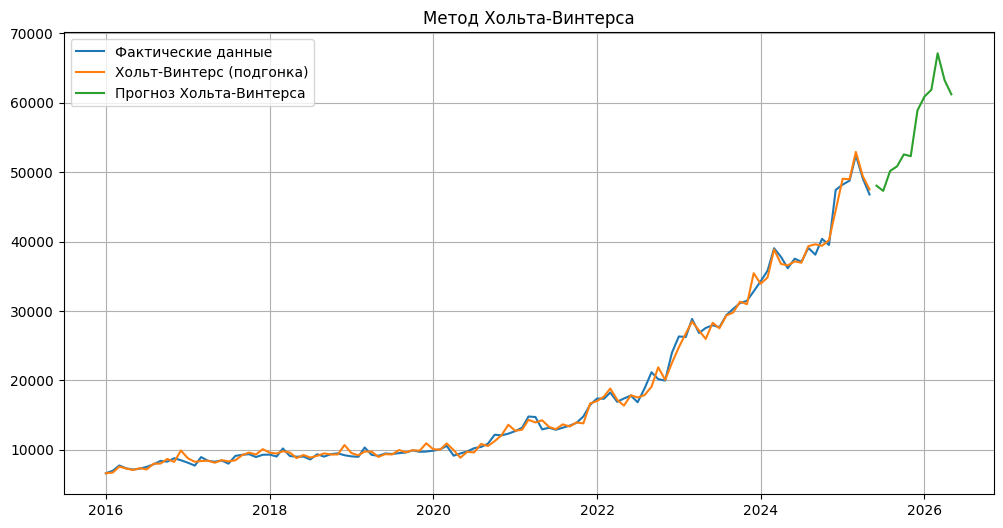

Хольт-Винтерс - MSE: 544112.73, MAPE: 3.42%


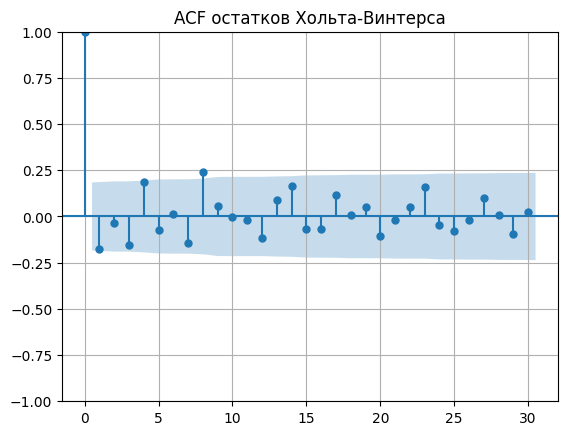


Тест Льюнга-Бокса на автокорреляцию остатков Хольта-Винтерса:
      lb_stat  lb_pvalue
12  23.224757   0.025877


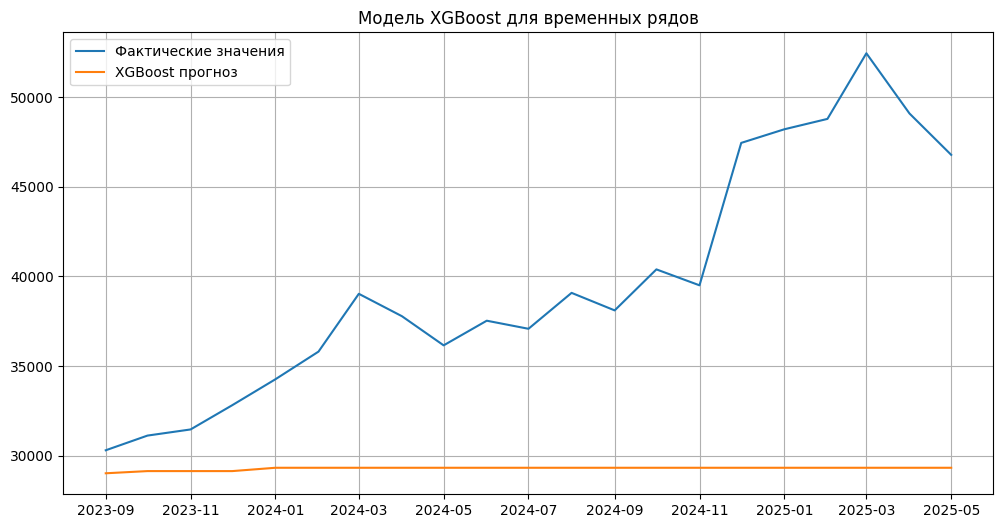

XGBoost - MSE: 148530485.46, MAPE: 24.30%

Сравнение моделей:
Хольт-Винтерс - MSE: 544112.73, MAPE: 3.42%
XGBoost - MSE: 148530485.46, MAPE: 24.30%
ACF остатков Holt-Winters:
Lag  0: 1.0000
Lag  1: -0.1773
Lag  2: -0.0341
Lag  3: -0.1525
Lag  4: 0.1855
Lag  5: -0.0725
Lag  6: 0.0137
Lag  7: -0.1458
Lag  8: 0.2382
Lag  9: 0.0583
Lag 10: -0.0049
Lag 11: -0.0213
Lag 12: -0.1189
Lag 13: 0.0893
Lag 14: 0.1663
Lag 15: -0.0664
Lag 16: -0.0687
Lag 17: 0.1166
Lag 18: 0.0065
Lag 19: 0.0515
Lag 20: -0.1080
Lag 21: -0.0215
Lag 22: 0.0516
Lag 23: 0.1590
Lag 24: -0.0486
Lag 25: -0.0775
Lag 26: -0.0209
Lag 27: 0.1022
Lag 28: 0.0054
Lag 29: -0.0935
Lag 30: 0.0241


<Figure size 800x400 with 0 Axes>

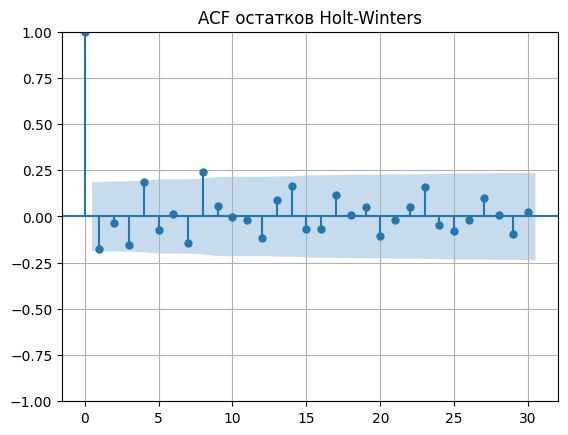

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox

# --- 1. Метод Хольта-Винтерса ---
series.index = pd.to_datetime(series.index)  # Преобразуем индекс в формат даты

# Построение модели Хольта-Винтерса
hw_model = ExponentialSmoothing(series, seasonal="mul", trend="mul", seasonal_periods=12)
hw_model_fitted = hw_model.fit()

hw = ExponentialSmoothing(
  series,
  trend='add', damped_trend=True,
  seasonal='add', seasonal_periods=12
).fit()


# Прогноз на будущее
hw_forecast = hw_model_fitted.forecast(steps=12)

# Визуализация результата
plt.figure(figsize=(12, 6))
plt.plot(series, label="Фактические данные")
plt.plot(hw_model_fitted.fittedvalues, label="Хольт-Винтерс (подгонка)")
plt.plot(hw_forecast, label="Прогноз Хольта-Винтерса")
plt.title("Метод Хольта-Винтерса")
plt.legend()
plt.grid(True)
plt.show()

# Оценка модели Хольта-Винтерса
hw_mse = mean_squared_error(series[-len(hw_model_fitted.fittedvalues):], hw_model_fitted.fittedvalues)
hw_mape = mean_absolute_percentage_error(series[-len(hw_model_fitted.fittedvalues):], hw_model_fitted.fittedvalues) * 100
print(f'Хольт-Винтерс - MSE: {hw_mse:.2f}, MAPE: {hw_mape:.2f}%')

# --- Проверка остатков Хольта-Винтерса на автокорреляцию ---
residuals_hw = series - hw_model_fitted.fittedvalues  # Остатки модели
plot_acf(residuals_hw.dropna(), lags=30)
plt.title("ACF остатков Хольта-Винтерса")
plt.grid(True)
plt.show()

ljungbox_hw = acorr_ljungbox(residuals_hw.dropna(), lags=[12], return_df=True)
print("\nТест Льюнга-Бокса на автокорреляцию остатков Хольта-Винтерса:")
print(ljungbox_hw)

# --- 2. Построение XGBoost для прогнозирования временных рядов ---
# Создание лаговых признаков
def create_lagged_features(series, lags=12):
    df = pd.DataFrame(series)
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[series.name].shift(lag)
    return df.dropna()

# Создаем лаги
lags = 12
lagged_data = create_lagged_features(series, lags=lags)

# Разделение данных на тренировочную и тестовую выборку
X = lagged_data.drop(series.name, axis=1)
y = lagged_data[series.name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Построение модели XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=4, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Прогноз на тестовой выборке
xgb_pred = xgb_model.predict(X_test)

# Визуализация результата
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Фактические значения")
plt.plot(y_test.index, xgb_pred, label="XGBoost прогноз")
plt.title("Модель XGBoost для временных рядов")
plt.legend()
plt.grid(True)
plt.show()

# Оценка модели XGBoost
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred) * 100
print(f'XGBoost - MSE: {xgb_mse:.2f}, MAPE: {xgb_mape:.2f}%')

# --- Сравнение результатов ---
print("\nСравнение моделей:")
print(f"Хольт-Винтерс - MSE: {hw_mse:.2f}, MAPE: {hw_mape:.2f}%")
print(f"XGBoost - MSE: {xgb_mse:.2f}, MAPE: {xgb_mape:.2f}%")


from statsmodels.tsa.stattools import acf

# --- Остатки модели Holt-Winters ---
residuals_hw = (series - hw_model_fitted.fittedvalues).dropna()

# --- 1) Расчёт ACF и вывод в консоль ---
nlags = 30
acf_vals = acf(residuals_hw, nlags=nlags)

print("ACF остатков Holt-Winters:")
for lag, val in enumerate(acf_vals):
    print(f"Lag {lag:2d}: {val:.4f}")

# --- 2) График ACF ---
plt.figure(figsize=(8,4))
plot_acf(residuals_hw, lags=nlags, alpha=0.05)
plt.title("ACF остатков Holt-Winters")
plt.grid(True)
plt.show()


SARIMAX – out-of-sample MAPE: 3.37%



<Figure size 800x400 with 0 Axes>

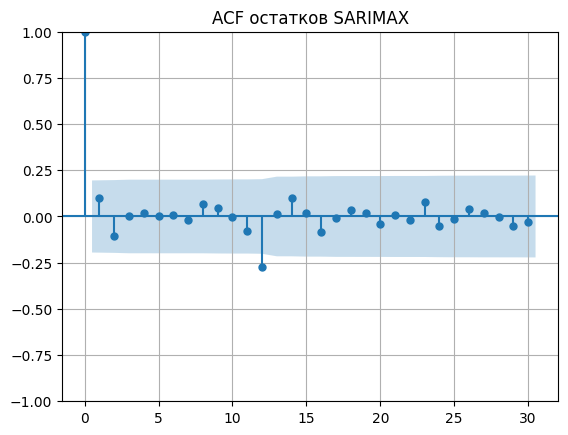

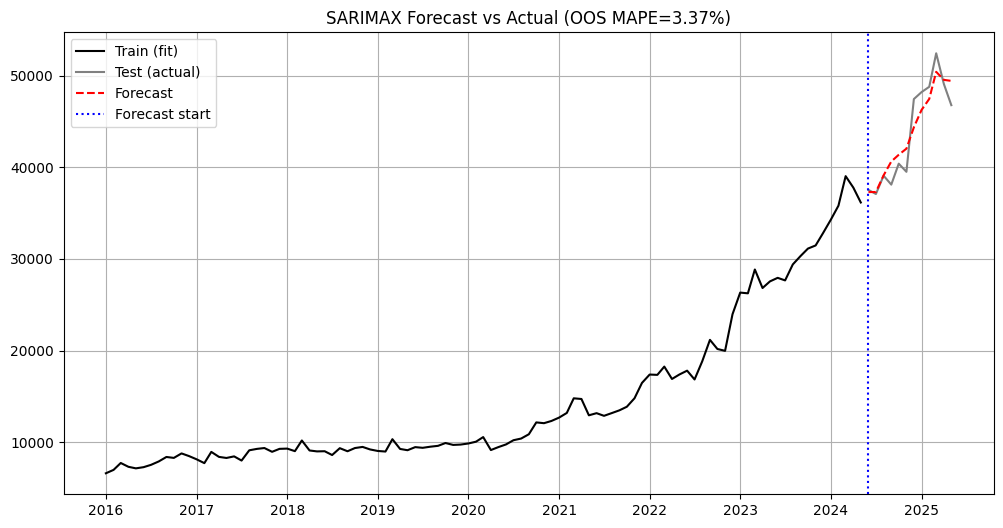

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_percentage_error

# 1) Задаём горизонт прогноза
horizon = 12

# 2) Делим ряд на train/test (последние 12 месяцев — тест)
series.index = pd.to_datetime(series.index)
series = series.asfreq('MS').dropna()
train, test = series[:-horizon], series[-horizon:]

# 3) Обучаем SARIMAX на train
model = sm.tsa.statespace.SARIMAX(
    train,
    order=(1,0,1),
    seasonal_order=(1,0,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# 4) Делаем прогноз именно на test.index
sarimax_fc = model.predict(start=test.index[0], end=test.index[-1])

# 5) Вычисляем OOS-MAPE
mape_oos = mean_absolute_percentage_error(test, sarimax_fc) * 100
print(f"SARIMAX – out-of-sample MAPE: {mape_oos:.2f}%\n")

# 6) Строим ACF остатков (in-sample)
resid = model.resid.dropna()
plt.figure(figsize=(8,4))
plot_acf(resid, lags=30, alpha=0.05)
plt.title("ACF остатков SARIMAX")
plt.grid(True)
plt.show()

# 7) Визуализируем train/test и прогноз
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train (fit)', color='black')
plt.plot(test.index,  test,  label='Test (actual)', color='gray')
plt.plot(sarimax_fc.index, sarimax_fc, 'r--', label='Forecast')
plt.axvline(test.index[0], color='blue', linestyle=':', label='Forecast start')
plt.title(f"SARIMAX Forecast vs Actual (OOS MAPE={mape_oos:.2f}%)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller
print(adfuller(resid.dropna()))


(np.float64(-7.464541866618207), np.float64(5.246487908526157e-11), 0, 110, {'1%': np.float64(-3.4912451337340342), '5%': np.float64(-2.8881954545454547), '10%': np.float64(-2.5809876033057852)}, np.float64(1631.2822958053125))


In [ ]:
!pip install Prophet

In [ ]:
# Предположим, что у вас есть pd.Series с датами в индексе и значениями
# 1. Сбросим индекс в колонки
df = series.reset_index()

# 2. Переименуем колонки в нужные Prophet-форматы
df.columns = ['ds', 'y']

# Убедимся, что ds — datetime, а y — числовая
df['ds'] = pd.to_datetime(df['ds'])
df['y']  = pd.to_numeric(df['y'])

from prophet import Prophet

m = Prophet(seasonality_mode='additive')
m.add_seasonality(name='quarter', period=3, fourier_order=5)
m.add_seasonality(name='two_year', period=24, fourier_order=8)

# Теперь fit пройдёт без ошибок
m.fit(df)

# Построим будущий фрейм на 12 месяцев после конца ряда
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)

# Извлечём прогнозы «yhat» с того момента, где кончаются реальные данные
start_fc = series.index.max() + pd.offsets.MonthBegin(1)
fc = forecast.set_index('ds')['yhat'].loc[start_fc:]
print(fc)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpknp8jqe6/kigf34oh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpknp8jqe6/p228o9k6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6225', 'data', 'file=/tmp/tmpknp8jqe6/kigf34oh.json', 'init=/tmp/tmpknp8jqe6/p228o9k6.json', 'output', 'file=/tmp/tmpknp8jqe6/prophet_modelpzw1tj_y/prophet_model-20250729112441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:24:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:24:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds
2025-06-01    49603.088262
2025-07-01    49640.791879
2025-08-01    51021.515545
2025-09-01    51277.520989
2025-10-01    52249.072689
2025-11-01    52630.252838
2025-12-01    54678.033375
2026-01-01    56098.397150
2026-02-01    56544.885774
2026-03-01    59072.021595
2026-04-01    57624.853229
2026-05-01    58338.654571
Name: yhat, dtype: float64


In-sample MAPE (Prophet): 4.91%


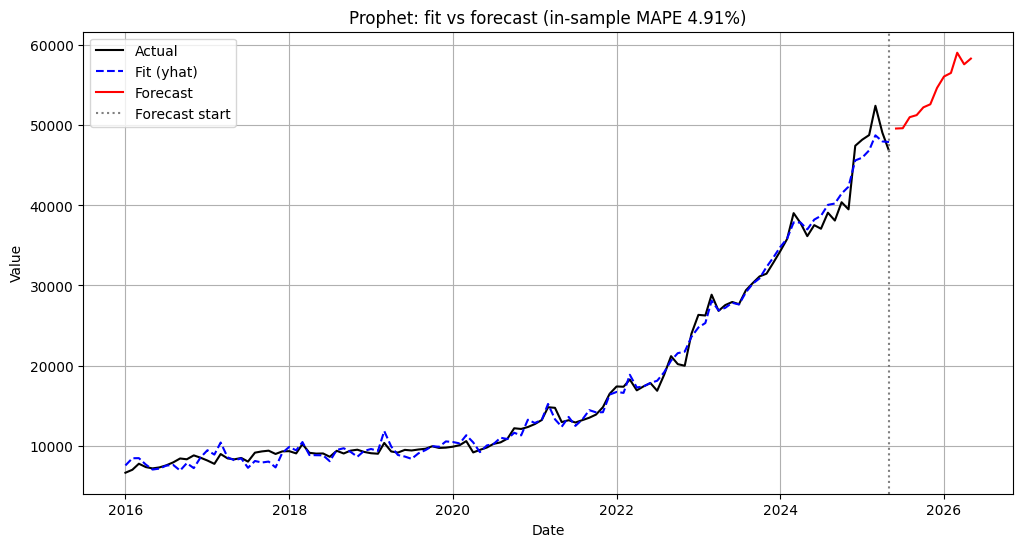

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Предположим, что:
# - series — ваш фактический pd.Series (индекс типа datetime, MS)
# - forecast — DataFrame из Prophet с колонками ['ds','yhat']
# - fc — серия прогнозных значений (yhat) с шагом MS после конца series

# 1. Подготовим прогнозы в-sample и out-of-sample
# Приводим forecast к Series с datetime-индексом
pred = forecast.set_index('ds')['yhat']

# In-sample (исторический) период
insamp_pred = pred.loc[series.index.min(): series.index.max()]

# Out-of-sample (прогнозный) период
start_fc = series.index.max() + pd.offsets.MonthBegin(1)
fc = pred.loc[start_fc:]

# 2. Вычислим MAPE на in-sample (подгонке)
mape_insample = mean_absolute_percentage_error(series, insamp_pred) * 100

print(f"In-sample MAPE (Prophet): {mape_insample:.2f}%")

# 3. Построим график
plt.figure(figsize=(12, 6))
plt.plot(series,       label='Actual',    color='black')
plt.plot(insamp_pred,  label='Fit (yhat)', linestyle='--', color='blue')
plt.plot(fc,           label='Forecast', linestyle='-',  color='red')
plt.axvline(series.index.max(), linestyle=':', color='gray', label='Forecast start')
plt.title(f"Prophet: fit vs forecast (in-sample MAPE {mape_insample:.2f}%)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# y_true_oos — реальные значения за период прогноза
# fc — серия прогнозов Prophet, которую мы уже получили

y_true_oos = series.loc[fc.index]
mape_oos = mean_absolute_percentage_error(y_true_oos, fc) * 100
print(f'Out-of-sample MAPE (Prophet): {mape_oos:.2f}%')


KeyError: "None of [DatetimeIndex(['2025-06-01', '2025-07-01', '2025-08-01', '2025-09-01',\n               '2025-10-01', '2025-11-01', '2025-12-01', '2026-01-01',\n               '2026-02-01', '2026-03-01', '2026-04-01', '2026-05-01'],\n              dtype='datetime64[ns]', name='ds', freq=None)] are in the [index]"


**Построение модели Хольта-Винтерса --**

Подогнанные значения модели (последние 4 мес.):
Date
2025-02-01    48388.725646
2025-03-01    51007.464977
2025-04-01    49711.873909
2025-05-01    48485.726654
Freq: MS, dtype: float64

Прогнозные значения (с 2025-06 по 2026-05):
2025-06-01    49085.321793
2025-07-01    48798.255072
2025-08-01    50933.790121
2025-09-01    51194.455885
2025-10-01    53527.640626
2025-11-01    53430.426797
2025-12-01    59403.483264
2026-01-01    59728.489519
2026-02-01    60185.133476
2026-03-01    63183.018882
2026-04-01    60066.073732
2026-05-01    59356.273118
Freq: MS, dtype: float64


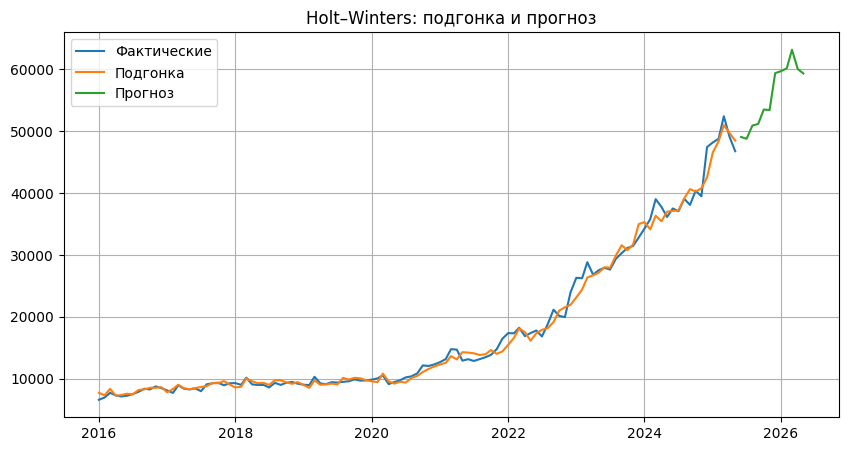

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- Предположим, что series загружен и проиндексирован по MS ---
series.index = pd.to_datetime(series.index)
series = series.asfreq('MS')

# --- Обучаем модель ---
hw = ExponentialSmoothing(
    series,
    trend='add',
    seasonal='add',
    seasonal_periods=12
)
hw_fit = hw.fit()

# --- Динамический срез подгонки (последние 4 месяца) ---
last_date = series.index.max()
start_date = last_date - pd.DateOffset(months=3)
fitted_slice = hw_fit.fittedvalues.loc[start_date:last_date]

print("Подогнанные значения модели (последние 4 мес.):")
print(fitted_slice)

# --- Прогноз с первого месяца после последнего наблюдения ---
forecast_start = last_date + pd.DateOffset(months=1)
horizon = 12
fc_index = pd.date_range(start=forecast_start, periods=horizon, freq='MS')

hw_fc = hw_fit.forecast(steps=horizon)
hw_fc.index = fc_index

print("\nПрогнозные значения (с {} по {}):".format(
    forecast_start.strftime('%Y-%m'),
    (forecast_start + pd.DateOffset(months=horizon-1)).strftime('%Y-%m')
))
print(hw_fc)

# --- Визуализация ---
plt.figure(figsize=(10, 5))
plt.plot(series, label='Фактические')
plt.plot(hw_fit.fittedvalues, label='Подгонка')
plt.plot(hw_fc, label='Прогноз')
#plt.axvspan(start_date, last_date, alpha=0.2,           label='Последние 4 подогнанные')
plt.title('Holt–Winters: подгонка и прогноз')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Метрики качества модели ---

# Удалим пропущенные значения, если они есть (например, в начале ряда подгонки)
actual = series.loc[hw_model_fitted.fittedvalues.index]
fitted = hw_model_fitted.fittedvalues

# MAPE (средняя абсолютная процентная ошибка)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(actual, fitted)
mae = mean_absolute_error(actual, fitted)
rmse = np.sqrt(mean_squared_error(actual, fitted))

# --- Вывод метрик ---
print("\nОценка точности модели:")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")



Оценка точности модели:
MAPE: 3.42%
MAE: 515.11
RMSE: 737.64


<Figure size 800x400 with 0 Axes>

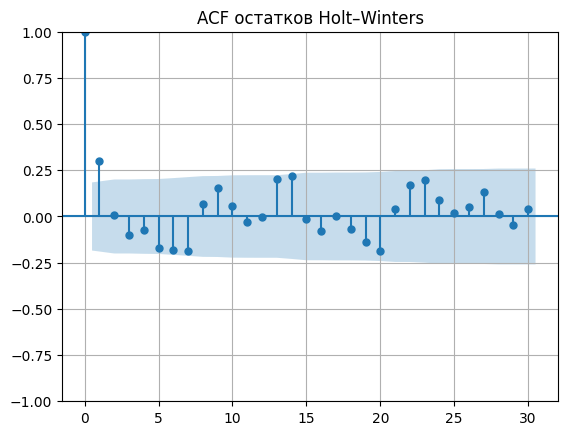

In [ ]:
# --- ACF остатков модели Holt–Winters ---
residuals = (series - hw_fit.fittedvalues).dropna()
plt.figure(figsize=(8, 4))
plot_acf(residuals, lags=30, alpha=0.05)
plt.title("ACF остатков Holt–Winters")
plt.grid(True)
plt.show()

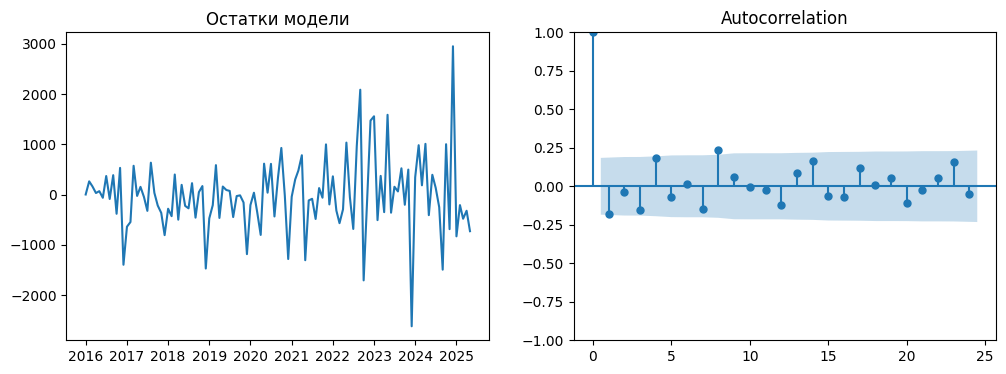

In [ ]:
import statsmodels.api as sm

resid = series - hw_model_fitted.fittedvalues
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(resid); plt.title("Остатки модели")
plt.subplot(122)
sm.graphics.tsa.plot_acf(resid.dropna(), lags=24, ax=plt.gca())
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(resid.dropna(), lags=[12,24], return_df=True)
print(lb_test)


      lb_stat  lb_pvalue
12  23.224757   0.025877
24  37.392279   0.039970


                                     SARIMAX Results                                      
Dep. Variable:                            series1   No. Observations:                  112
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 109.792
Date:                            Tue, 29 Jul 2025   AIC                           -215.583
Time:                                    11:26:03   BIC                           -210.393
Sample:                                02-01-2016   HQIC                          -213.483
                                     - 05-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4330      0.088     -4.926      0.000      -0.605      -0.261
sigma2         0.0062      0.001   

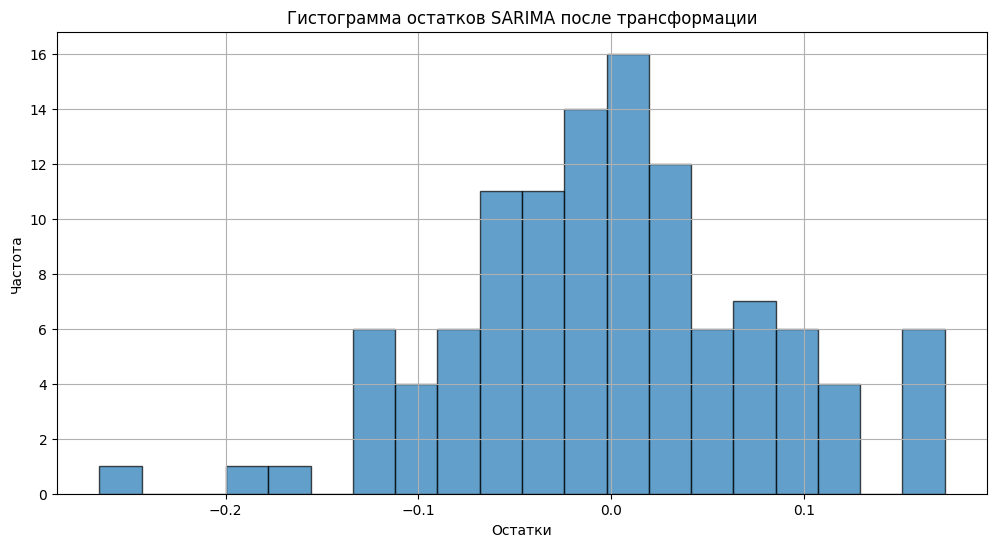

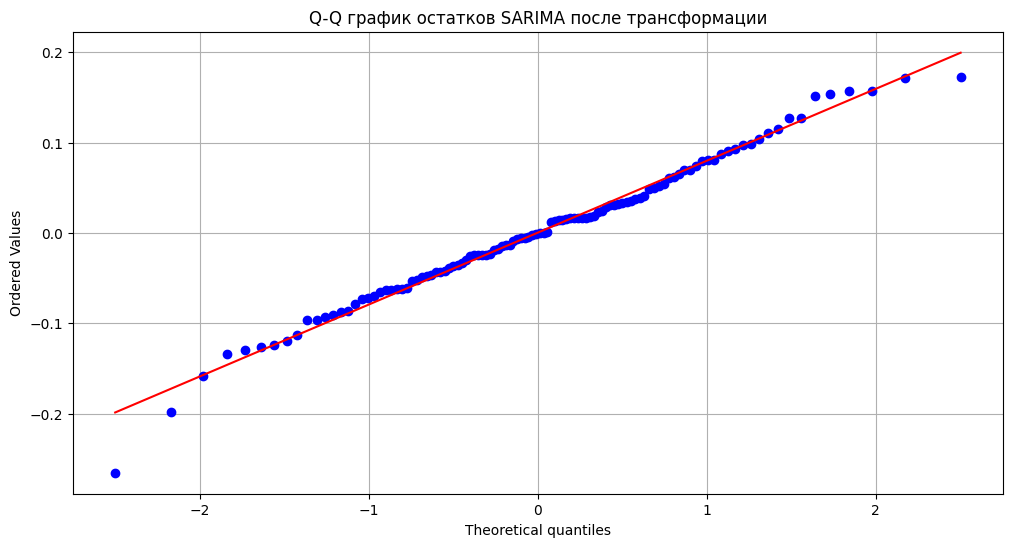

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import shapiro, anderson, cramervonmises, probplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# Преобразование данных
series_log = np.log(series)
series_diff = series_log.diff().dropna()

# Построение модели SARIMA на преобразованных данных
sarima_model = SARIMAX(series_diff, order=(0, 1, 0), seasonal_order=(1, 1, 0, 12))
sarima_model_fitted = sarima_model.fit(disp=False)
print(sarima_model_fitted.summary())

# Получение остатков SARIMA
sarima_residuals = sarima_model_fitted.resid
print(sarima_residuals)

# Оценка модели на обучающей выборке (train series)
train_series_pred = sarima_model_fitted.predict(start=series_diff.index[0], end=series_diff.index[-1])
mse = mean_squared_error(series_diff, train_series_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(series_diff, train_series_pred)
mape = mean_absolute_percentage_error(series_diff, train_series_pred) * 100  # В процентах

print(f'\nОценка модели на обучающей выборке:')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')


# Оценка модели на всей выборке (full series)
# Генерация предсказаний на полный временной интервал
full_series_pred = sarima_model_fitted.predict(start=series_diff.index[0], end=series.index[-1])

# Убедитесь, что длина прогноза совпадает с фактическими значениями для расчета метрик
full_series_diff = series_log.diff().dropna()  # Преобразуем всю выборку
mape_full = mean_absolute_percentage_error(full_series_diff, full_series_pred) * 100  # Рассчитываем MAPE

print(f'\nОценка модели на полной выборке:')
print(f'MAPE (на всей выборке): {mape_full:.2f}%')


# Тесты на нормальность остатков
# Тест Шапиро-Уилка
shapiro_test = shapiro(sarima_residuals)
print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}')

# Тест Андерсона-Дарлинга
anderson_test = anderson(sarima_residuals)
print('\nAnderson-Darling Test:')
print(f'Statistic: {anderson_test.statistic:.4f}')
for i in range(len(anderson_test.critical_values)):
    sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
    if anderson_test.statistic < cv:
        result = 'Accept'
    else:
        result = 'Reject'
    print(f'At {sl}% significance level: Critical Value = {cv:.4f}, Result = {result}')

# Тест Крамера-фон Мизеса
cramervonmises_test = cramervonmises(sarima_residuals, 'norm')
print('\nCramer-Von Mises Test:')
print(f'Statistic: {cramervonmises_test.statistic:.4f}, p-value: {cramervonmises_test.pvalue:.4f}')

# Тест Льюнга-Бокса на автокорреляцию
ljungbox_test = acorr_ljungbox(sarima_residuals, lags=[12], return_df=True)
print('\nLjung-Box Test (lag=12):')
print(ljungbox_test)

# Диагностика остатков SARIMA
plt.figure(figsize=(12, 6))
plt.hist(sarima_residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Гистограмма остатков SARIMA после трансформации')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Q-Q график для проверки нормальности остатков
plt.figure(figsize=(12, 6))
probplot(sarima_residuals, dist="norm", plot=plt)
plt.title('Q-Q график остатков SARIMA после трансформации')
plt.grid(True)
plt.show()


Даты в индексе от начала до конца:
2016-01-01 00:00:00 до 2024-12-01 00:00:00
Индекс является монотонным: True

Модель: SARIMA (0,1,0)(1,0,0,12)
                                     SARIMAX Results                                      
Dep. Variable:                            series1   No. Observations:                  108
Model:             SARIMAX(0, 2, 0)x(1, 1, 0, 12)   Log Likelihood                -721.299
Date:                            Tue, 29 Jul 2025   AIC                           1446.598
Time:                                    11:26:48   BIC                           1451.412
Sample:                                01-01-2016   HQIC                          1448.531
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

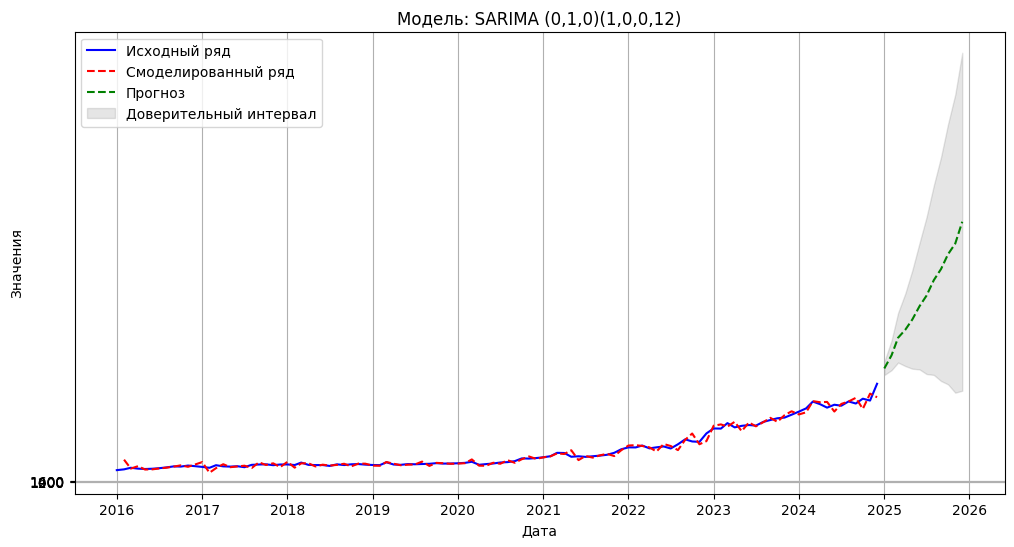

Прогнозные значения на 2024 год:
                  Прогноз  Нижний доверительный интервал  \
2025-01-01   54694.306670                   51559.512778   
2025-02-01   60884.088696                   53874.476458   
2025-03-01   69208.316486                   57478.991764   
2025-04-01   72994.273869                   55824.300591   
2025-05-01   77824.262802                   54576.009081   
2025-06-01   84134.007421                   54229.979600   
2025-07-01   89146.994128                   52055.612588   
2025-08-01   96416.630292                   51642.817853   
2025-09-01  101684.594943                   48763.183088   
2025-10-01  108688.418294                   47179.320533   
2025-11-01  113745.612069                   43230.167167   
2025-12-01  124073.584211                   44151.708074   

            Верхний доверительный интервал  
2025-01-01                    57829.100562  
2025-02-01                    67893.700935  
2025-03-01                    80937.641209  
2025-0

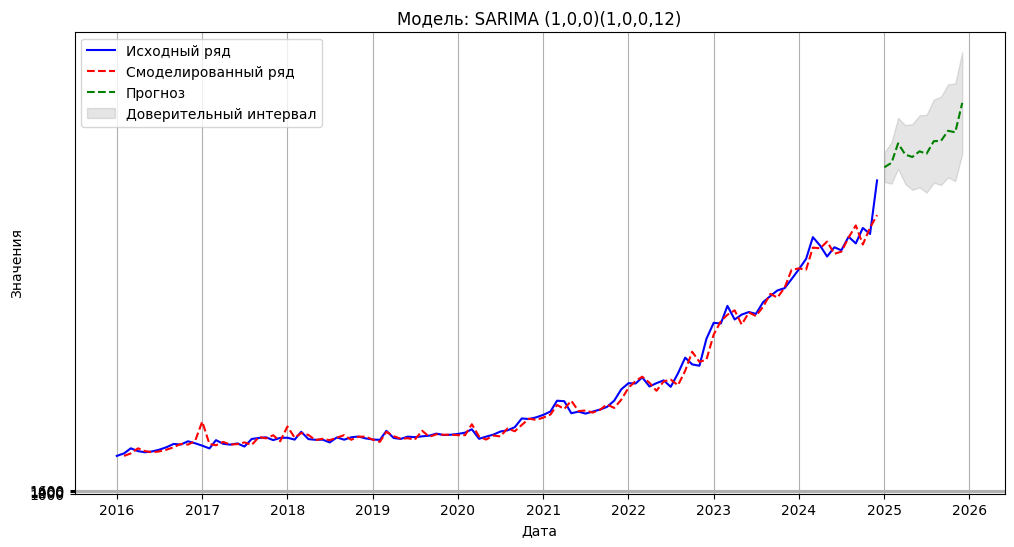

Прогнозные значения на 2024 год:
                 Прогноз  Нижний доверительный интервал  \
2025-01-01  49389.965639                   47209.046512   
2025-02-01  50050.556510                   46966.271104   
2025-03-01  52933.900802                   49156.438068   
2025-04-01  51266.078073                   46904.239821   
2025-05-01  50918.690439                   46042.007019   
2025-06-01  51755.310662                   46413.171633   
2025-07-01  51397.916076                   45627.746439   
2025-08-01  53258.960220                   47090.389407   
2025-09-01  53308.738886                   46765.981508   
2025-10-01  54796.921342                   47900.249511   
2025-11-01  54577.672695                   47344.382256   
2025-12-01  58936.339798                   51381.414331   

            Верхний доверительный интервал  
2025-01-01                    51570.884765  
2025-02-01                    53134.841917  
2025-03-01                    56711.363536  
2025-04-01         

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Проверка диапазона дат
print("Даты в индексе от начала до конца:")
print(series.index.min(), "до", series.index.max())

# Установка корректных start_date и end_date в соответствии с индексом
start_date = '2016-01'
end_date = '2025-06'

# Обрезка данных для периода с 2015-01-01 по 2023-12-31
series = series.loc[start_date:end_date]

# Проверка монотонности индекса
print("Индекс является монотонным:", series.index.is_monotonic_increasing)

# Параметры более простых моделей SARIMA
models = [
    {
        'order': (0, 2, 0),
        'seasonal_order': (1, 1, 0, 12),
        'description': 'SARIMA (0,1,0)(1,0,0,12)'
    },
    {
        'order': (0, 1,0),
        'seasonal_order': (1, 1, 0, 12),
        'description': 'SARIMA (1,0,0)(1,0,0,12)'
    }
]

# Период прогнозирования
forecast_steps = 12  # Прогноз на 12 месяцев (на 2024 год)
forecast_index = pd.date_range(start='2025-01', periods=forecast_steps, freq='MS')

# Цикл по моделям
for model_params in models:
    print(f"\nМодель: {model_params['description']}")

    # Обучение модели
    try:
        model = SARIMAX(
            series,
            order=model_params['order'],
            seasonal_order=model_params['seasonal_order'],
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
    except Exception as e:
        print(f"Ошибка при обучении модели {model_params['description']}: {e}")
        continue

    # Вывод summary модели
    print(results.summary())

    # Получение смоделированных значений в исходном масштабе
    fitted_values = results.predict(start=series.index[1], end=series.index[-1], typ='levels')

    # Прогнозирование на 2024 год
    forecast = results.get_forecast(steps=forecast_steps)
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()
    forecast_conf_int.index = forecast_index
    forecast_values.index = forecast_index

    # Построение графика
    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series, label='Исходный ряд', color='blue')
    plt.plot(fitted_values.index, fitted_values, label='Смоделированный ряд', color='red', linestyle='--')
    plt.plot(forecast_values.index, forecast_values, label='Прогноз', color='green', linestyle='--')
    plt.fill_between(forecast_conf_int.index,
                     forecast_conf_int.iloc[:, 0],
                     forecast_conf_int.iloc[:, 1],
                     color='k', alpha=0.1, label='Доверительный интервал')
    plt.xlabel('Дата')
    plt.ylabel('Значения')
    plt.title(f"Модель: {model_params['description']}")
    plt.yticks(np.arange(1000, 1601, 200))  # Изменение шкалы по оси y
    plt.legend()
    plt.grid(True)
    plt.show()

    # Вывод прогнозных значений
    print("Прогнозные значения на 2024 год:")
    forecast_df = pd.DataFrame({
        'Прогноз': forecast_values,
        'Нижний доверительный интервал': forecast_conf_int.iloc[:, 0],
        'Верхний доверительный интервал': forecast_conf_int.iloc[:, 1]
    }, index=forecast_index)
    print(forecast_df)

    # Сохранение прогнозных значений в Excel (опционально)
    forecast_df.to_excel(f"Forecast_{model_params['description']}.xlsx")
    print(f"Прогноз сохранен в файл 'Forecast_{model_params['description']}.xlsx'")